# Configuration & Tools

In [3]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


used refrences:


1-https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/PolicyGradient/DDPG/pytorch/lunar-lander


2-https://www.youtube.com/watch?v=hlv79rcHws0


3-https://github.com/MrSyee/pg-is-all-you-need

## Import modules

In [4]:
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal
# added libraries
import copy # neeed it for OUi noise

## Set random seed

In [5]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [19]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initialize."""
        # ==================================== Your Code (Begin) ====================================
        self.index_indicator = 0 # indicator for where put new data in memory
        self.flag_full = False # to indicate if memory is full and we should rewrite data from start
        self.batch_size = batch_size
        self.full_size = size
        self.action_mem = np.zeros((size,)) # action is continus so we just need one column for each memory unit
        self.states_mem = np.zeros((size,obs_dim))
        self.reward_mem = np.zeros((size,))
        self.next_states_mem = np.zeros((size,obs_dim))
        self.termination_flag_mem = np.zeros((size,))

        # ==================================== Your Code (End) ====================================


    def store(self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        # ==================================== Your Code (Begin) ====================================
        self.states_mem[self.index_indicator] = obs
        self.action_mem[self.index_indicator] = act
        self.reward_mem[self.index_indicator] = rew
        self.next_states_mem[self.index_indicator] = next_obs
        self.termination_flag_mem[self.index_indicator] = done
        self.index_indicator += 1
        if self.index_indicator >= self.full_size: #if memory is full, we start to rewrite memory from start
          self.flag_full = True
          self.index_indicator = 0






        
        # ==================================== Your Code (End) ====================================


    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        # ==================================== Your Code (Begin) ====================================
        if self.flag_full:
          size_mem = self.full_size 
        else:
          size_mem = self.index_indicator
        all_index = np.arange(0,size_mem)
        np.random.shuffle(all_index)
        chosen_batch = all_index[0:self.batch_size]
        states =self.states_mem[chosen_batch,:]
        next_states = self.next_states_mem[chosen_batch,:]
        actions  =self.action_mem[chosen_batch] 
        rewards = self.reward_mem[chosen_batch]
        termination_flags = self.termination_flag_mem[chosen_batch]
        batch_dict = dict(states = states,next_states = next_states,actions = actions,rewards = rewards,termination_flags = termination_flags)
        return batch_dict
        # ==================================== Your Code (End) ====================================


    def __len__(self) -> int:
        # ==================================== Your Code (Begin) ====================================
        if self.flag_full:
          size_mem  = self.full_size
        else:
          size_mem = self.index_indicator
        return size_mem
        # ==================================== Your Code (End) ====================================


## OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference: 
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [7]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

# PPO

- PPO: [J. Schulman et al., "Proximal Policy Optimization Algorithms." arXiv preprint arXiv:1707.06347, 2017.](https://arxiv.org/abs/1707.06347.pdf)
- TRPO: [Schulman, John, et al. "Trust region policy optimization." International conference on machine learning. 2015.](http://proceedings.mlr.press/v37/schulman15.pdf)

There are two kinds of algorithms of PPO: PPO-Penalty and PPO-Clip. Here, we'll implement PPO-clip version.

TRPO computes the gradients with a complex second-order method. On the other hand, PPO tries to solve the problem with a first-order methods that keep new policies close to old. To simplify the surrogate objective, let $r(\theta)$ denote the probability ratio

$$ L^{CPI}(\theta) = \hat {\mathbb{E}}_t \left [ {\pi_\theta(a_t|s_t) \over \pi_{\theta_{old}}(a_t|s_t)} \hat A_t\right] = \hat {\mathbb{E}}_t \left [ r_t(\theta) \hat A_t \right ].$$

The objective is penalized further away from $r_t(\theta)$

$$ L^{CLIP}(\theta)=\hat {\mathbb{E}}_t \left [ \min(r_t(\theta) \hat A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat A_t) \right ] $$

If the advantage is positive, the objective will increase. As a result, the action becomes more likely. If advantage is negative, the objective will decrease. AS a result, the action becomes less likely.

# DDPG 

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). 

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target netwokrs is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

# Networks


## PPO Networks

We will use two separated networks for actor and critic respectively. The actor network consists of two fully connected hidden layer with ReLU branched out two fully connected output layers for mean and standard deviation of Gaussian distribution. Pendulum-v0 has only one action which has a range from -2 to 2. In order to fit the range, the actor outputs the mean value with tanh. The result will be scaled in ActionNormalizer class. On the one hand, the critic network has three fully connected layers as two hidden layers (ReLU) and an output layer. One thing to note is that we initialize the last layers' weights and biases as uniformly distributed.

In [8]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    # ==================================== Your Code (Begin) ====================================
    layer.weight.data.uniform_(-1*init_w, init_w)
    layer.bias.data.fill_(0)
    return layer
    
    # ==================================== Your Code (End) ====================================


class PPOActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        log_std_min: int = -20,
        log_std_max: int = 0,
    ):
        """Initialize."""
        super(PPOActor, self).__init__()

        

        # ==================================== Your Code (Begin) ====================================
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        hidden_layer_size = 32  # we assume that all hidden layer have same amount of nodes
        self.hidden_layer = nn.Sequential( #encoder part of network
          nn.Linear(in_dim,hidden_layer_size),
          nn.ReLU(),
          nn.Linear(hidden_layer_size,hidden_layer_size),
          nn.ReLU(),

        )
        self.out_layer_mu = nn.Linear(hidden_layer_size,out_dim)
        self.out_layer_mu = init_layer_uniform(self.out_layer_mu)
        self.out_layer_log_std =  nn.Linear(hidden_layer_size,out_dim)
        self.out_layer_log_std = init_layer_uniform(self.out_layer_log_std)
        self.tanh_layer = nn.Tanh()
        # ==================================== Your Code (End) ====================================


    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        
        # ==================================== Your Code (Begin) ====================================
        # return selected action and a normal distribution as output of this module
        hidden_encoded = self.hidden_layer(state)
        output_mu = self.out_layer_mu(hidden_encoded)
        output_mu = self.tanh_layer(output_mu) #mean head

        output_log_std = self.out_layer_log_std(hidden_encoded) 
        output_log_std = self.tanh_layer(output_log_std)# std head
        output_log_std = self.log_std_min + ((self.log_std_max-self.log_std_min)/(2))*(1 + output_log_std) #scaling to given range
        normal_dist = Normal(output_mu,torch.exp(output_log_std)) #fittin distribution
        action = normal_dist.sample()
        return normal_dist
        # ==================================== Your Code (End) ====================================



class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()
        # ==================================== Your Code (Begin) ====================================
        hidden_layer_size = 32  
        self.hidden_layer = nn.Sequential(
          nn.Linear(in_dim,hidden_layer_size),
          nn.ReLU(),
          nn.Linear(hidden_layer_size,hidden_layer_size),
          nn.ReLU()
        )
        self.out_layer = nn.Linear(hidden_layer_size,1)
        self.out_layer = init_layer_uniform(self.out_layer)
    
        # ==================================== Your Code (End) ====================================


    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        # ==================================== Your Code (Begin) ====================================
        hidden_encoded = self.hidden_layer(state)
        output = self.out_layer(hidden_encoded)
        return output
        # ==================================== Your Code (End) ====================================


## DDPG Networks
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, **ReLU** for hidden layers and **tanh** for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers **ReLU**. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are **uniformly distributed.**

In [9]:
class DDPGActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(DDPGActor, self).__init__()
        # ==================================== Your Code (Begin) ====================================
        # 1. set the hidden layers
        # 2. init hidden layers uniformly
        hidden_layer_size = 128  
        self.hidden_layer = nn.Sequential(
          nn.Linear(in_dim,hidden_layer_size),
          nn.ReLU(),
          nn.Linear(hidden_layer_size,hidden_layer_size),
          nn.ReLU()
        )
        self.out_layer = nn.Linear(hidden_layer_size,out_dim)#using function defined in previous cell to initialize weights
        self.out_layer = init_layer_uniform(self.out_layer)
        self.tanh_layer = nn.Tanh()

      
        # ==================================== Your Code (End) ====================================

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        # ==================================== Your Code (Begin) ====================================
        # use a tanh function as a ativation function for output layer 
        hidden_encoded = self.hidden_layer(state)
        output = self.out_layer(hidden_encoded)
        output_nonlinear = self.tanh_layer(output)
        return output_nonlinear
        # ==================================== Your Code (End) ====================================
    
    
class DDPGCritic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(DDPGCritic, self).__init__()
        
        # ==================================== Your Code (Begin) ====================================
        # 1. set the hidden layers
        # 2. init hidden layers uniformly  
        hidden_layer_size = 128  
        self.hidden_layer = nn.Sequential(
          nn.Linear(in_dim,hidden_layer_size),
          nn.ReLU(),
          nn.Linear(hidden_layer_size,hidden_layer_size),
          nn.ReLU()
        )
        self.out_layer = nn.Linear(hidden_layer_size,1)
        self.out_layer = init_layer_uniform(self.out_layer)
    
         
        # ==================================== Your Code (End) ====================================

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        # ==================================== Your Code (Begin) ====================================
        # notice that this value function is Q(s, a)
        input = torch.cat((state,action),dim = 1)
        hidden_encoded = self.hidden_layer(input)
        output = self.out_layer(hidden_encoded)
        return output


        # ==================================== Your Code (End) ====================================


# Agents 

## PPO Agent
Here is a summary of PPOAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|_plot             | plot the training progresses.                        |


PPO updates the model several times(`epoch`) using the stacked memory. By `ppo_iter` function, It yield the samples of stacked memory by interacting a environment.

In [10]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    
    # ==================================== Your Code (Begin) ====================================
    # we could both return indexes or yield batches directly, because function asked us Yield mini-batches.
    for i in range(epoch):
      indexes = np.arange(0,states.size(0)) 
      np.random.shuffle(indexes)#shuffling so we choose randomly, but all indexes will participate in this process
      for j in range((states.size(0))//mini_batch_size):
        chosen_indexes = indexes[(j)*mini_batch_size:(j+1)*mini_batch_size]
        yield states[chosen_indexes,:],actions[chosen_indexes],values[chosen_indexes],log_probs[chosen_indexes],returns[chosen_indexes],advantages[chosen_indexes]
    # ==================================== Your Code (End) ====================================


In [74]:
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): batch size for sampling
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)        
    """

    def __init__(
        self,
        env: gym.Env,
        batch_size: int,
        gamma: float,
        tau: float,
        epsilon: float,
        epoch: int,
        rollout_len: int,
        entropy_weight: float,
    ):
        """Initialize."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set hyperparameters
        # 2. check device: cpu/GPU
        # 3. init actor critic networks
        # 4. set Optimizer for each network
        # 5. consider memory for training
        # 6. set total step counts equal to 1
        # 7. define a mode for train/test
        #1
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight
        #2
        device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device
        
        #3 and 4
        self.actor = PPOActor(self.env.observation_space.shape[0],self.env.action_space.shape[0])
        self.actor.to(self.device)
        self.optim_actor = torch.optim.Adam(self.actor.parameters(),lr = 0.001)



        self.critic = Critic(self.env.observation_space.shape[0])
        self.critic.to(self.device)
        self.optim_crit = torch.optim.Adam(self.critic.parameters(),lr = 0.005)

        #5 important note: PPO is on policy, so we don't use our replay buffer, but instead we use lists and after each episode we delet them
        self.states = []
        self.log_probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.values = []

        # 6
        self.total_step_count = 0
        #7
        self.train_flag = True






        # ==================================== Your Code (End) ====================================

    
        

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # ==================================== Your Code (Begin) ====================================
        # 1. select action for train or test mode
        # 2. if you are in train mode take care of filing considered memory

        state = torch.tensor(state,dtype = torch.float32)
        state.to(self.device)
        dist = self.actor(state)
        if self.train_flag:
          action = dist.sample()
          value = self.critic(state)
          self.states.append(state)
          self.log_probs.append(dist.log_prob(action))
          self.actions.append(action)
          self.values.append(value)
        else:
          action = dist.mean #argmax of gaussian distribution is it's mid
        return np.array([action.cpu().item()])


        # ==================================== Your Code (End) ====================================


    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        # ==================================== Your Code (Begin) ====================================
        next_state, reward, done, _ = self.env.step(action)
        next_state_shape = len(next_state)
        next_state_batch = np.reshape(next_state,(1,next_state_shape) )
        reward_batched = np.reshape(reward, (1,1))
        done_batch = np.reshape(done, (1,1))
        if  self.train_flag:
          
          self.rewards.append(torch.tensor(reward_batched,dtype = torch.float32).to(self.device))
          self.dones.append(torch.tensor(done_batch,dtype = torch.float32).to(self.device))

        return next_state_batch, reward_batched, done_batch
        # ==================================== Your Code (End) ====================================


    def update_model(
        self, next_state: np.ndarray
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set device
        # 2. for each step:
        # 3.    calculate ratios
        # 4.    calculate actor_loss
        # 5.    calculate entropy
        # 6.    calculate critic_loss
        # 7.    Train  critic
        # 8.    Train actor

        #1 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #we already saved device in torch.device
        next_state = torch.tensor(next_state,dtype = torch.float32)
        next_state.to(device)
        next_value = self.critic(next_state)


        # gae:
        values = self.values
        values = values + [next_value]
        
        gae = 0
        returns_all = []
        gamma = self.gamma
        dones = self.dones
        tau = self.tau
        rewards = self.rewards
        counter = np.arange(len(rewards)-1,-1,-1)
        for step in counter:
            delta = (rewards[step]+ gamma * values[step + 1] * (1-dones[step])- values[step])
            gae = delta + gamma * tau * (1-dones[step]) * gae
            returns_all.append(gae + values[step])
        
        returns = []
        len_list = len(returns_all)
        for i in range(len(returns_all)):
          returns.append(returns_all[len_list -i - 1])
        returns = torch.cat(returns).detach()
        values_all = torch.cat(self.values).detach()
        advantage_gae = returns - values_all
        states_all = torch.cat(self.states)
        states_all = states_all.view(-1,3)
        actions_all = torch.cat(self.actions)
        log_probs_all = torch.cat(self.log_probs).detach()
        actor_losses = 0
        critic_losses = 0
        counter_batch = 0
        # using defined function to sample from temprory memory
        for state, action, value_prv, log_prob_prv, returns_batch, advantages in ppo_iter(epoch=self.epoch,mini_batch_size=self.batch_size,states=states_all,actions=actions_all,values=values_all,log_probs=log_probs_all,returns=returns,advantages=advantage_gae):
          normal_dist = self.actor(state)
          
          values_critic = self.critic(state)
          MSE_loss = nn.MSELoss()
         # critic_loss = MSE_loss(values_critic,returns_batch) for some reason using pytorch mse didn't give us good results.
          critic_loss = (returns_batch - values_critic).pow(2).mean() 

          self.optim_crit.zero_grad()
          critic_loss.backward(retain_graph=True)
          critic_losses += (critic_loss.item())
          self.optim_crit.step()
          

         
          #entropy loss
          entropy_loss = self.entropy_weight*normal_dist.entropy().mean()
          # calculating ratios

          log_prob_new = normal_dist.log_prob(action)
          log_ratio = log_prob_new - log_prob_prv
          pie_ratio = log_ratio.exp()
          loss_main_actor = pie_ratio*advantages

          loss_main_actor_clipped = torch.clamp(pie_ratio,1-self.epsilon, 1 + self.epsilon)*advantages
          loss_main_total = torch.min(loss_main_actor,loss_main_actor_clipped)
          loss_actor = -loss_main_total.mean() - entropy_loss #putting them alltogether
          
         

          self.optim_actor.zero_grad()
          loss_actor.backward()
          self.optim_actor.step()
          actor_losses += (loss_actor.item())
          counter_batch+= 1
        self.states = []
        self.log_probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.values = []

        actor_loss_total = (actor_losses)/(counter_batch)
        critic_loss_total = (critic_losses)/counter_batch
        return actor_loss_total,critic_loss_total
        





        # ==================================== Your Code (End) ====================================

    

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        # 2. Reset environment
        # 3. for number of frames:
        # 4.    select an action
        # 5.    step in environment
        # 6.    update model
        # 7. terminate environment after training is finished
        self.train_flag = True
        state = self.env.reset()
        state = np.expand_dims(state, axis=0)
        actor_loss_list = []
        critic_loss_list = []
        reward_list = []
        reward_counter = 0
        for i in range(num_frames ):
          for roll_out_counter in range(self.rollout_len):
            self.total_step_count += 1
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            state = next_state
            reward_counter += reward[0][0]

            if(sum(done)):
              reward_list.append(reward_counter)
              reward_counter = 0
              self._plot(self.total_step_count, reward_list, actor_loss_list, critic_loss_list)
              state = self.env.reset()
              state = np.expand_dims(state, axis=0)
            if((self.total_step_count%plotting_interval) == 0):
              self._plot(self.total_step_count, reward_list, actor_loss_list, critic_loss_list)

          actor_loss,critic_loss = self.update_model(next_state)
          actor_loss_list.append(actor_loss)
          critic_loss_list.append(critic_loss)
          if self.total_step_count >= num_frames:
            break
        self.env.close()




        # ==================================== Your Code (End) ====================================

        

    def test(self):
        """Test the agent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        # 2. Reset environment
        # 3. roll out one episode living in the environment and save frames for getting render

        self.train_flag = False
        state = self.env.reset()
        frame_list = []
        while(True):
          action = self.select_action(state)
          next_state, reward, done = self.step(action)
          frame_list.append(self.env.render(mode="rgb_array"))
          state = next_state
          if(done):
            break
        self.env.close()
        return frame_list
        # ==================================== Your Code (End) ====================================


    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        # ==================================== Your Code (Begin) ====================================
        # 1. define a function for sub plots
        # 2. for each variable plot the specific subplot
        # 3. plot the whole figure

        clear_output(True)
        
        plt.figure(figsize=(25, 5))
        plt.subplot(1,3,1)
        plt.plot(scores)
        plt.title(f"frame index = {frame_idx}")

        plt.subplot(1,3,2)
        plt.plot(actor_losses)
        plt.title(f"actor losses")

        plt.subplot(1,3,3)
        plt.plot(critic_losses)
        plt.title('critic losses')

        plt.show()
        # ==================================== Your Code (End) ====================================


## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [12]:
class DDPGAgent:
    """DDPGAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
    ):
        """Initialize."""

        # ==================================== Your Code (Begin) ====================================
        # 1. initialize hyper parameters, reply buffer and environment
        # 2. set device
        # 3. set target entropy, log alpha and alpha optimizer
        # 4. init actor network
        # 5. init value fuction (value critic)
        # 6. init OUNoise 
        # 7. set Optimizers
        # consider stroring transitions in memeory, counting steps and specify train/test mode

        self.env = env
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.ou_noise_theta = ou_noise_theta
        self.ou_noise_sigma = ou_noise_sigma
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.OUNoise = OUNoise(size = 1,mu = 0,sigma =self.ou_noise_sigma,theta = self.ou_noise_theta )
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.device = DEVICE
        # defining networks
        self.actor = DDPGActor(self.env.observation_space.shape[0],1)
        self.actor.to(self.device)
        self.optim_actor = torch.optim.Adam(self.actor.parameters(),lr = 0.5*(1e-3))

        self.critic = DDPGCritic(self.env.observation_space.shape[0]+1)
        self.critic.to(self.device)
        self.optim_crit = torch.optim.Adam(self.critic.parameters(),lr = (1e-4))

        self.actor_target =  DDPGActor(self.env.observation_space.shape[0],1)
        self.actor_target.to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict()) # we added this line so our two networks have same starting point

        self.critic_target = DDPGCritic(self.env.observation_space.shape[0]+1)
        self.critic_target.to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict()) # we added this line so our two networks have same starting point

        self.memory = ReplayBuffer(self.env.observation_space.shape[0],self.memory_size,self.batch_size)

        self.train_flag = True
        self.step_count = 0

        self.state_temp_mem = []
        self.action_temp_mem = []
        self.next_state_tem_mem = []
        self.reward_temp_mem = []
        self.flag_termination_temp_mem = []



        
        # ==================================== Your Code (End) ====================================
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        
        # ==================================== Your Code (Begin) ====================================
        # 1. check if initial random action should be conducted
        # 2. add noise for exploration during training
        # 3. store transition
        # return selected action
        
        tensor_state = torch.tensor(state,dtype = torch.float32).to(self.device)
        if ((self.train_flag) and (self.step_count<self.initial_random_steps)):
          action_chosen = self.env.action_space.sample() # it is by itself, a numpy array so we don't need to convert it
        elif self.train_flag:
          #action_chosen = np.array([self.actor(tensor_state).cpu().item()])
          action_chosen=  self.actor(tensor_state).detach().cpu().numpy()
        
          OUI_noise_sample = self.OUNoise.sample()
          action_chosen = action_chosen + OUI_noise_sample
        else:
        #  action_chosen = np.array([self.actor(tensor_state).cpu().item()])
          action_chosen = self.actor(tensor_state).detach().cpu().numpy()
        self.action_temp_mem = action_chosen
        self.state_temp_mem = state
        
        
        return action_chosen

        # ==================================== Your Code (End) ====================================
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        # ==================================== Your Code (Begin) ====================================
        # step in environment and save transition in memory if you are not in test mode
        next_state, reward, done, _ = self.env.step(action)
        if self.train_flag:
          self.memory.store(self.state_temp_mem,self.action_temp_mem,reward,next_state,done)
        return next_state, reward, done

        # ==================================== Your Code (End) ====================================
    
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set device
        # 2. get a batch from memory and calculate the return
        # 3. calculate the loss for actor and critic networks
        # 4. update target
        # 1
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # 2 get batch
        batch = self.memory.sample_batch()
        state_batch = torch.tensor(batch['states'],dtype = torch.float32).to(device)
        next_state_batch = torch.tensor(batch['next_states'],dtype = torch.float32).to(device)
        action_batch = torch.unsqueeze(torch.tensor(batch['actions'],dtype = torch.float32).to(device),1)
        rewards_batch = torch.unsqueeze(torch.tensor(batch['rewards'],dtype = torch.float32).to(device),1)
        termination_flag_batch = torch.unsqueeze(torch.tensor(batch['termination_flags'],dtype = torch.float32).to(device),1)
        # 3, get estimate retun for critic network error
        action_target = self.actor_target(next_state_batch)
        value_target = self.critic_target(next_state_batch,action_target)
        return_estimate = rewards_batch + self.gamma*(value_target*(1-termination_flag_batch))

        # 3 critic train
        values_critic = self.critic(state_batch,action_batch)
        MSE_loss = nn.MSELoss()
        self.optim_crit.zero_grad()
        critic_loss = MSE_loss(values_critic,return_estimate)
        critic_loss.backward()
        self.optim_crit.step()

        #3 actor train
        action_actor = self.actor(state_batch)
        actor_loss = -1*self.critic(state_batch,action_actor).mean() # gradient accending
        self.optim_actor.zero_grad()
        actor_loss.backward()
        self.optim_actor.step()

        # 4 update target
        self._target_soft_update()
        actor_loss_data = actor_loss.cpu().data
        critic_loss_data = critic_loss.cpu().data
        return actor_loss_data,critic_loss_data

        
        
        # ==================================== Your Code (End) ====================================
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        # 2. Reset environment
        # 3. for number of frames:
        # 4.    select an action
        # 5.    step in environment
        # 6.    update model
        # 7. plot the computed variables
        # 8. terminate environment after training is finished
        # ==================================== Your Code (End) ====================================
        #1
        self.train_flag = True
        actor_loss_list = []
        critic_loss_list = []
        reward_list = []
        reward_counter = 0
        #2
        state = self.env.reset()
        #3
        for i in range(num_frames):
          self.step_count = i
          action = self.select_action(state)
          next_state, reward, done = self.step(action)
          reward_counter = reward_counter + self.gamma*reward
          state = next_state
          if (self.batch_size < len(self.memory)):
            if(i > self.initial_random_steps):
              actor_loss_data,critic_loss_data = self.update_model()
              actor_loss_list.append(actor_loss_data)
              critic_loss_list.append(critic_loss_data)
          if done:
            state = self.env.reset()
            reward_list.append(reward_counter)
            reward_counter = 0
          if (i%plotting_interval == 0):
            self._plot(i,reward_list,actor_loss_list,critic_loss_list)
        self.env.close()




            





    def test(self):
        """Test the agent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        # 2. Reset environment
        # 3. roll out one episode living in the environment and save frames for getting render

        self.train_flag = False
        state = self.env.reset()
        frame_list = []
        while(True):
          action = self.select_action(state)
          next_state, reward, done = self.step(action)
          frame_list.append(self.env.render(mode="rgb_array"))
          state = next_state
          if(done):
            break
        self.env.close()
        return frame_list
        



        # ==================================== Your Code (End) ====================================
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        # ==================================== Your Code (Begin) ====================================
        actor_w = self.actor.state_dict()
        actor_target_network_w = self.actor_target.state_dict()
        for layer in actor_w:
          actor_target_network_w[layer] = self.tau*actor_w[layer] + (1.0-self.tau)*actor_target_network_w[layer]
        self.actor_target.load_state_dict(actor_target_network_w)

        critic_w = self.critic.state_dict()
        critic_target_network_w = self.critic_target.state_dict()
        for layer in critic_w:
          critic_target_network_w[layer] = self.tau*critic_w[layer] + (1.0-self.tau)*critic_target_network_w[layer]
        self.critic_target.load_state_dict(critic_target_network_w)



        # ==================================== Your Code (End) ====================================
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        # ==================================== Your Code (Begin) ====================================
        clear_output(True)
        
        plt.figure(figsize=(25, 5))
        plt.subplot(1,3,1)
        plt.plot(scores)
        plt.title(f"frame index = {frame_idx}")

        plt.subplot(1,3,2)
        plt.plot(actor_losses)
        plt.title(f"actor losses")

        plt.subplot(1,3,3)
        plt.plot(critic_losses)
        plt.title('critic losses')

        plt.show()


     
        # ==================================== Your Code (End) ====================================

# Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [13]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        # ==================================== Your Code (Begin) ====================================

        min_val = self.action_space.low
        max_val = self.action_space.high
        action_scaled = ((max_val-min_val)/2)*action + (max_val + min_val)/2
        return np.clip(action_scaled,min_val,max_val)
        
        # ==================================== Your Code (End) ====================================

    

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        # ==================================== Your Code (Begin) ====================================
        min_val = self.action_space.low
        max_val = self.action_space.high
        action_scaled = (action - ((min_val + max_val)/2))/((max_val - min_val)/2)
        return np.clip(action_scaled,-1,1)
        
        # ==================================== Your Code (End) ====================================


You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v1 from OpenAI's repository.

In [64]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id)
env = ActionNormalizer(env)
env.seed(seed)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[777]

# Train & Test 

## Initialize

In [65]:
# parameters
num_frames = 50000
memory_size = 20000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

ppo_agent = PPOAgent(
    env,
    gamma = 0.9,
    tau = 0.8,
    batch_size = 64,
    epsilon = 0.2,
    epoch = 64,
    rollout_len = 2048,
    entropy_weight = 0.005
)

ddpg_agent = DDPGAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps
)

## Train PPO

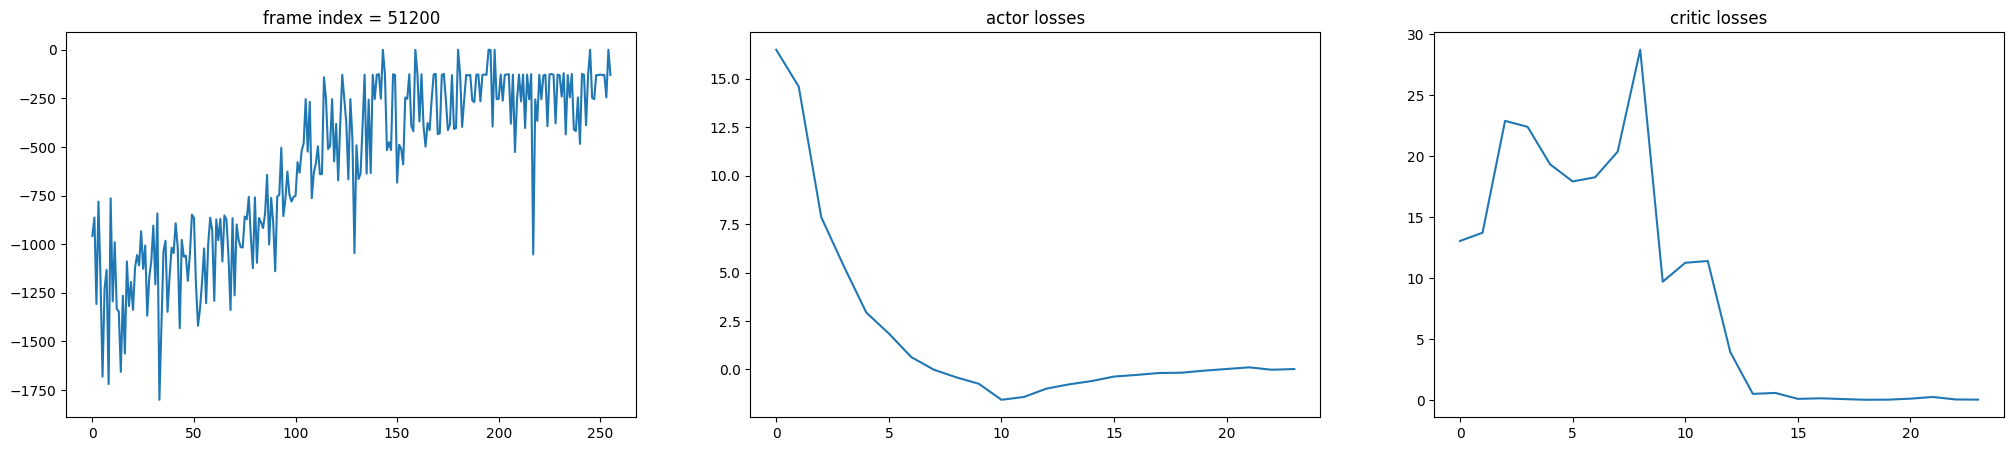

In [44]:
ppo_agent.train(num_frames)

## Train DDPG

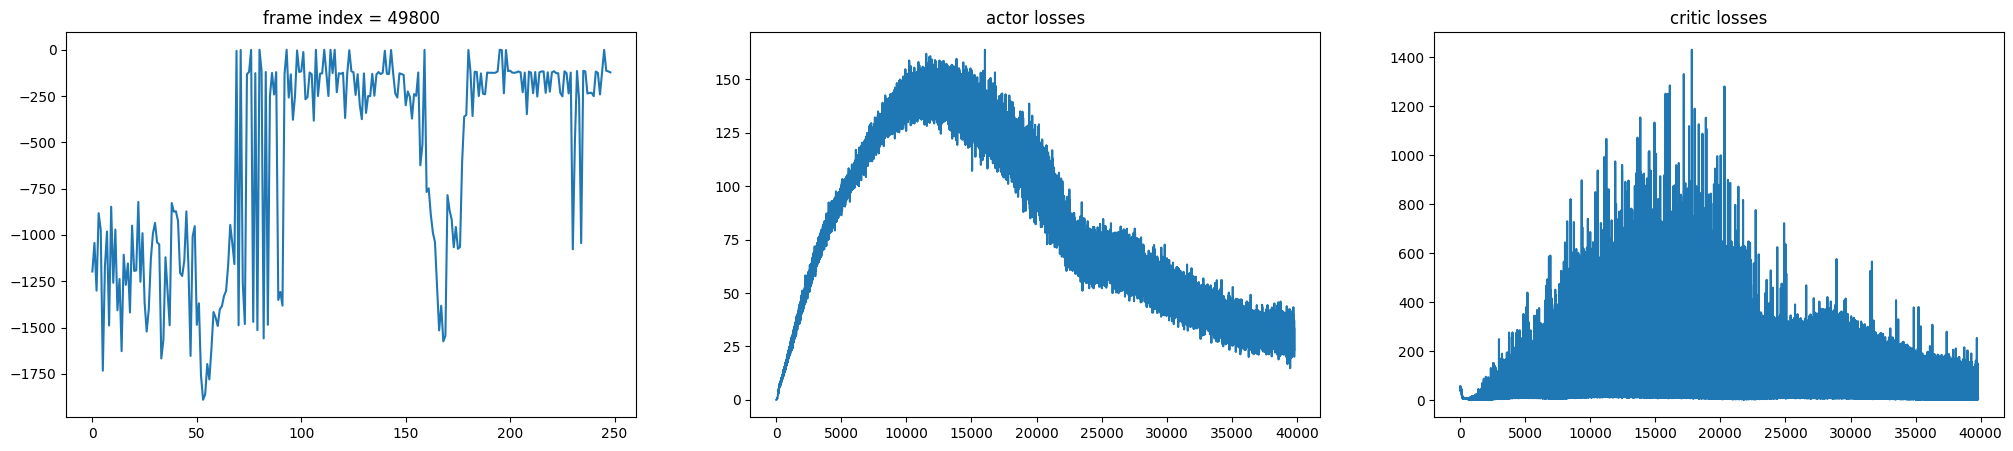

In [66]:
ddpg_agent.train(num_frames)

## Test

for plotting, we used RecordVideo from gym.wraperr, also we plot result for this two in seperate cells, first for ppo and then ddpg

In [45]:
# test
from gym.wrappers import RecordVideo

if IN_COLAB:
    ppo_agent.env = RecordVideo(ppo_agent.env, "videos")
   # ddpg_agent.env = RecordVideo(ddpg_agent.env, "videos")
ppo_frames = ppo_agent.test()
#ddpg_frames = ddpg_agent.test()

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See 

## Render

In [46]:
if IN_COLAB:  # for colab
    import base64
    import glob
    import io
    import os

    from IPython.display import HTML, display

    def ipython_show_video(path: str) -> None:
        """Show a video at `path` within IPython Notebook."""
        if not os.path.isfile(path):
            raise NameError("Cannot access: {}".format(path))

        video = io.open(path, "r+b").read()
        encoded = base64.b64encode(video)

        display(HTML(
            data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>
            """.format(encoded.decode("ascii"))
        ))

    list_of_files = glob.glob("videos/*.mp4")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    ipython_show_video(latest_file)

else:  # for jupyter
    from matplotlib import animation
    from JSAnimation.IPython_display import display_animation
    from IPython.display import display


    def display_frames_as_gif(frames):
        """Displays a list of frames as a gif, with controls."""
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames = len(frames), interval=50
        )
        display(display_animation(anim, default_mode='loop'))


    # display 
    display_frames_as_gif(ppo_frames)
   # display_frames_as_gif(ddpg_frames)

videos/rl-video-episode-0.mp4


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
# test
from gym.wrappers import RecordVideo

if IN_COLAB:
   # ppo_agent.env = RecordVideo(ppo_agent.env, "videos")
    ddpg_agent.env = RecordVideo(ddpg_agent.env, "videos2")
#ppo_frames = ppo_agent.test()
ddpg_frames = ddpg_agent.test()

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initializ

In [75]:
if IN_COLAB:  # for colab
    import base64
    import glob
    import io
    import os

    from IPython.display import HTML, display

    def ipython_show_video(path: str) -> None:
        """Show a video at `path` within IPython Notebook."""
        if not os.path.isfile(path):
            raise NameError("Cannot access: {}".format(path))

        video = io.open(path, "r+b").read()
        encoded = base64.b64encode(video)

        display(HTML(
            data="""
            <video alt="test" controls>
            <source src="data:videos2/mp4;base64,{0}" type="video/mp4"/>
            </video>
            """.format(encoded.decode("ascii"))
        ))

    list_of_files = glob.glob("videos2/*.mp4")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    ipython_show_video(latest_file)

else:  # for jupyter
    from matplotlib import animation
    from JSAnimation.IPython_display import display_animation
    from IPython.display import display


    def display_frames_as_gif(frames):
        """Displays a list of frames as a gif, with controls."""
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames = len(frames), interval=50
        )
        display(display_animation(anim, default_mode='loop'))


    # display 
   # display_frames_as_gif(ppo_frames)
    display_frames_as_gif(ddpg_frames)

videos2/rl-video-episode-0.mp4


if we want to compare the results, we can say that DDPG learns in a slower rate, but it do it job perfect, in a way that just by one action it do it job and keep pendulum completly vertical but ppo also achived good results, but not as good as DDPG